In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import io
from zipfile import ZipFile

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
r = requests.get(url)
z = ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('./ml-100k/u.data', '\t', names=names)
num_users = len(data.user_id.unique())
num_items = len(data.item_id.unique())

data = data.sample(frac=1)
train_indices = int(0.9 * data.shape[0])

train_data = data[:train_indices]
test_data = data[train_indices:]

train_rating_matrix = np.zeros((num_items, num_users))
test_rating_matrix = np.zeros((num_items, num_users))

for row in train_data.itertuples():
  user_id, item_id = row[1], row[2]
  train_rating_matrix[item_id-1][user_id-1] = 1.

for row in test_data.itertuples():
  test_rating_matrix[item_id-1][user_id-1] = 1.

In [ ]:
class AutoRec(Model):
  def __init__(self, num_hidden, num_users):
    super().__init__()

    self.encoder = layers.Dense(num_hidden,
                                kernel_regularizer=regularizers.l2(1e-5),
                                activation='sigmoid')
    
    self.decoder = layers.Dense(num_users,
                                kernel_regularizer=regularizers.l2(1e-5))

  def call(self, inputs, training=None):
    hidden = self.encoder(inputs)
    outputs = self.decoder(hidden)
    outputs = tf.nn.sigmoid(outputs)
    outputs = outputs * 4 + 1
    if training:
      return outputs * tf.sign(inputs)
    else:
      return outputs

model = AutoRec(500, num_users)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x=train_rating_matrix,
    y=train_rating_matrix,
    batch_size=256,
    epochs=25
)

Epoch 1/25
7/7 [==============================] - 1s 38ms/step - loss: 0.1327 - root_mean_squared_error: 0.3459
Epoch 2/25
7/7 [==============================] - 0s 38ms/step - loss: 0.0220 - root_mean_squared_error: 0.0935
Epoch 3/25
7/7 [==============================] - 0s 37ms/step - loss: 0.0141 - root_mean_squared_error: 0.0270
Epoch 4/25
7/7 [==============================] - 0s 36ms/step - loss: 0.0135 - root_mean_squared_error: 0.0140
Epoch 5/25
7/7 [==============================] - 0s 38ms/step - loss: 0.0131 - root_mean_squared_error: 0.0102
Epoch 6/25
7/7 [==============================] - 0s 36ms/step - loss: 0.0127 - root_mean_squared_error: 0.0087
Epoch 7/25
7/7 [==============================] - 0s 36ms/step - loss: 0.0122 - root_mean_squared_error: 0.0082
Epoch 8/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0117 - root_mean_squared_error: 0.0080
Epoch 9/25
7/7 [==============================] - 0s 41ms/step - loss: 0.0112 - root_mean_squared_error:

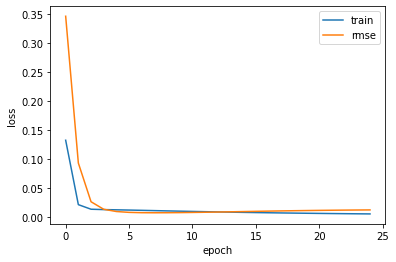

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["root_mean_squared_error"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "rmse"], loc="upper right")
plt.show()